In [1]:
import numpy as np 
import pandas as pd 
from nltk.tokenize import WordPunctTokenizer, TreebankWordTokenizer    
from nltk.stem import WordNetLemmatizer
import string
import nltk
import re
from nltk.corpus import stopwords

In [2]:
fake =pd.read_csv("Fake.csv")

In [3]:
real=pd.read_csv("True.csv")

In [4]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [5]:
fake["class"]=0.0

In [6]:
fake=fake[["text","class"]]

In [7]:
# nltk.download('stopwords')
lem = WordNetLemmatizer()
fake['text']=fake['text'].str.lower()
# Remove Punctuations
fake['text']=fake['text'].str.replace(r'[^\w\d\s]',' ')
#Remove the whitespaces
fake['text']=fake['text'].str.replace(r'\s+',' ')
#Removing links
fake['text']=fake['text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
fake['text']=fake['text'].str.replace(r'\d+(\.\d+)?','num')
stop_words = set(stopwords.words('english'))
#Removing the stop words
fake['text']=fake['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
#Stemming the words
fake['text']=fake['text'].apply(lambda x: ' '.join(lem.lemmatize(term) for term in str(x).split()))

In [8]:

unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])


In [9]:
real["text"] = tmp_text
del publisher, tmp_text, record, unknown_publishers
real['class']=1.0
real=real[['text','class']]

In [10]:
real['text']=real['text'].str.lower()
# Remove Punctuations
real['text']=real['text'].str.replace(r'[^\w\d\s]',' ')
#Remove the whitespaces
real['text']=real['text'].str.replace(r'\s+',' ')
#Removing links
real['text']=real['text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
real['text']=real['text'].str.replace(r'\d+(\.\d+)?','num')
#Remove tags from the text
real['text']=real['text'].str.replace(r'\@[a-zA-Z]+','')
stop_words = set(stopwords.words('english'))
#Removing the stop words
real['text']=real['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
#Stemming the words
real['text']=real['text'].apply(lambda x: ' '.join(lem.lemmatize(term) for term in str(x).split()))

In [11]:
concat=pd.concat([real,fake],ignore_index=True)


In [12]:
concat = concat.sample(frac=1).reset_index(drop=True)

In [13]:
count = concat.text.str.split().apply(len).value_counts()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
count

0 words:       632
1 words:        17
10 words:       56
100 words:      55
1002 words:      2
              ... 
990 words:       2
991 words:       2
993 words:       2
994 words:       3
999 words:       1
Name: text, Length: 1067, dtype: int64

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 5,ngram_range=(1,2),max_features=5000)

In [48]:
feature_vector=tfidf.fit_transform(concat['text']).todense()


In [50]:
tfidf_vocab=tfidf.vocabulary_
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
tfidf_reversed_vocab 

{536: 'britain',
 3828: 'said',
 2750: 'monday',
 4939: 'would',
 982: 'create',
 2857: 'new',
 2812: 'national',
 1313: 'economic',
 990: 'crime',
 656: 'center',
 978: 'crack',
 1917: 'harder',
 2752: 'money',
 2404: 'laundering',
 1292: 'drug',
 1061: 'dealer',
 3191: 'people',
 1498: 'expected',
 2852: 'net',
 2925: 'num',
 459: 'billion',
 3313: 'pound',
 4972: 'year',
 4700: 'unit',
 1489: 'existing',
 104: 'agency',
 3716: 'response',
 183: 'among',
 4372: 'tackle',
 1735: 'fraud',
 2118: 'increasing',
 2189: 'interior',
 2712: 'minister',
 2148: 'initiative',
 3140: 'part',
 3119: 'package',
 2640: 'measure',
 3740: 'review',
 961: 'country',
 203: 'announced',
 4511: 'today',
 4063: 'significantly',
 2102: 'improve',
 8: 'ability',
 3992: 'serious',
 633: 'case',
 1404: 'ensuring',
 4529: 'tool',
 2206: 'investment',
 2838: 'need',
 2200: 'investigate',
 992: 'criminal',
 305: 'asset',
 4224: 'statement',
 3244: 'plan',
 1491: 'exit',
 1453: 'european',
 4699: 'union',
 3511: 

In [ ]:
x = pd.DataFrame(feature_vector)
y= concat['class'] 

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=.3,random_state=1)
X_train

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,Y_train)
lr.score(X_test,Y_test)

In [ ]:
lr.score(X_train,Y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth =2, n_estimators=100)
rf.fit(X_train,Y_train)
rf.score(X_test,Y_test)

In [ ]:
rf.score(X_train,Y_train)

In [ ]:
len(x)

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes = [1, 100, 500, 2000, 5000,10000, 30000, 35918]
train_sizes, train_scores, validation_scores = learning_curve(LogisticRegression(),x,y, train_sizes = train_sizes, cv = 5, scoring = 'accuracy')


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('ACCURACY', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 1000
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concat.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108605 unique tokens.


In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(concat.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X= np.array(X,dtype=np.float32)

In [23]:
from sklearn.model_selection import train_test_split
Y = pd.get_dummies(concat['class'].values)
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (44898, 2)
(40408, 1000) (40408, 2)
(4490, 1000) (4490, 2)


In [24]:
import tensorflow as tf
X_train=tf.cast(X_train,tf.float32)
Y_train=tf.cast(Y_train,tf.float32)
X_test=tf.cast(X_test,tf.float32)
Y_test=tf.cast(Y_test,tf.float32)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
569/569 [==============================] - 3360s 6s/step - loss: 0.1184 - accuracy: 0.9587 - val_loss: 0.0492 - val_accuracy: 0.9847
Epoch 2/5
569/569 [==============================] - 3154s 6s/step - loss: 0.0287 - accuracy: 0.9913 - val_loss: 0.0393 - val_accuracy: 0.9879
Epoch 3/5
569/569 [==============================] - 3310s 6s/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0483 - val_accuracy: 0.9879
Epoch 4/5
569/569 [==============================] - 3454s 6s/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0420 - val_accuracy: 0.9889
Epoch 5/5
569/569 [==============================] - 3273s 6s/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.0557 - val_accuracy: 0.9884


In [21]:
model.save("saved_model1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model1\assets


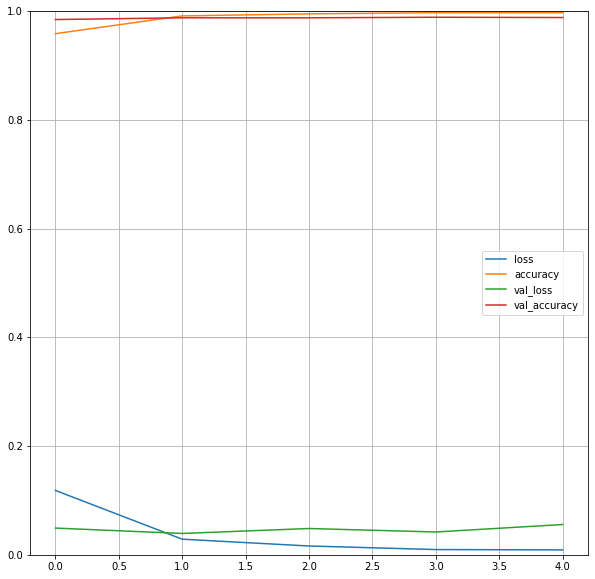

In [19]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [22]:
acc=model.evaluate(X_test,Y_test)
print('Loss : {} ,Accuracy : {}'.format(acc[0],acc[1]*100))


141/141 [==============================] - 30s 216ms/step - loss: 0.0562 - accuracy: 0.9895
Loss : 0.05619898438453674 ,Accuracy : 98.95322918891907


In [21]:
# This cell will be made predict_rnn.py
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import numpy as np
import re
import string

import numpy as np
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
#nltk.download('stopwords')
stopwords_english = stopwords.words('english')

def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retext text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # tokenize texts
    tokenizer = WordPunctTokenizer()
    text_tokens = tokenizer.tokenize(text)
    text_tokens = [word for word in text_tokens if word.isalpha()]
    texts_clean = []
    for word in text_tokens:
        if (word  not in stopwords_english and  # remove stopwords
            word  not in string.punctuation):  # remove punctuation
            # texts_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            texts_clean.append(stem_word)
    text=' '.join(texts_clean)
    return text
def predict_news_rnn(text):
    text = process_text(text)
    text=pd.Series([text],dtype='string')
    MAX_NB_WORDS = 10000
    MAX_SEQUENCE_LENGTH = 1000
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(text.values)
    X = tokenizer.texts_to_sequences(text.values)
#     print(X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    X = tf.cast(X,tf.float32)
    model=tf.keras.models.load_model('saved_model1')
    prediction = model.predict(X)
    print(prediction)
    pred = np.argmax(prediction)
    if pred==0:
        print("False News!!")
    else:
        print("Real News!!")

In [55]:
text ='Kanye West Sets Off July 4th Fireworks With White House 2020 Bid; “Power” Rapper Plans To Take On Trump & Biden'
# Outputting same prediction for every input
predict_news_rnn(fake['text'][30])

[[1.3013725e-04 9.9986982e-01]]
Real News!!


In [51]:
# This cell will be made predict_logistic.py
from sklearn.feature_extraction.text import TfidfVectorizer
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retext text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # tokenize texts
    tokenizer = WordPunctTokenizer()
    text_tokens = tokenizer.tokenize(text)
    text_tokens = [word for word in text_tokens if word.isalpha()]
    texts_clean = []
    for word in text_tokens:
        if (word  not in stopwords_english and  # remove stopwords
            word  not in string.punctuation):  # remove punctuation
            # texts_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            texts_clean.append(stem_word)
    text=' '.join(texts_clean)
    return text
def predict_news_logistic(text):
    tfidf = TfidfVectorizer( 
                             sublinear_tf = True,
                             use_idf = True,
                             max_features = 5000)
    text = process_text(text)
    text=pd.Series([text],dtype='string')
       
    feature_vector=tfidf.fit_transform(text).todense()
    shape=np.shape(feature_vector)
    # Trying to map the length of features on which the logistic regression was trained
    a=np.zeros((1,5000))
    #Appending the vector to the a vector
    a[:shape[0],:shape[1]]=feature_vector
    # passing the array 
    x = pd.DataFrame(a)
    return lr.predict(x)

In [53]:
text ='With merely four months to go for polling day on November 3, West has not confirmed whether he has submitted the official paperwork required to appear on state election ballots. He is also yet to clarify whether he will be running as an Independent candidate or if he has any party affiliations.According to a BBC report, his name does not appear in the Federal Election Commission (FEC) database for the upcoming Presidential election in November. The closest name is a candidate called ‘Kanye Deez Nutz West’, who registered with the FEC in 2015, using the address ‘1977 Golddigger Avenue, Suite Yeezus’, BBC reported.'
# Prediction is same 
predict_news_logistic(real['text'][1])

array([0.])

In [54]:
predict_news_logistic(fake['text'][1])

array([0.])